In [289]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
import os
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
import cv2 as cv
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
from keras import layers
from keras.optimizers import Adam
import cv2
from sklearn.utils import shuffle
from matplotlib.font_manager import FontProperties
from bidi.algorithm import get_display
from arabic_reshaper import arabic_reshaper
arabic_font = FontProperties(fname='font/NotoNaskhArabic-VariableFont_wght.ttf') 


In [19]:
data_path = 'seg_train\seg_train'  
data_path_for_test = 'seg_test\seg_test'

هنا تم قرائة الصور و الفئة التابعة الصورة لها 
وقمنا بتطبيق عملية تغير الحجم للتوحيد الحجم لجميع الصور 

In [20]:
image_dimensions = (128, 128)  
def load_and_process_images(path):
    images = []  
    labels = []  
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)  
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file)  
                try:
                    image = cv.imread(image_path,cv.IMREAD_GRAYSCALE)
                    # plt.imshow(image,cmap='gray')
                    # plt.show()
                    image=cv.resize(image,image_dimensions)
                    # plt.imshow(image,cmap='gray')
                    # plt.show()
                    images.append(image)
                    labels.append(folder)
                except Exception as e:
                    print("خطأ في قراءة الصورة:", image_path)
                    print(e)
    images = np.array(images,dtype='float32')
    labels = np.array(labels)
    return images, labels    

In [21]:
images, labels = load_and_process_images(data_path)
images = images/ 255

label_to_number = {label: number for number, label in enumerate(np.unique(labels))}
labels = np.array([label_to_number[label] for label in labels],dtype='int32')
labels = to_categorical(labels)
images = np.array(images).reshape(14034, image_dimensions[0]* image_dimensions[1])

In [22]:
images_test, labels_test = load_and_process_images(data_path_for_test)
images_test = images_test / 255

label_to_number_test = {label: number for number, label in enumerate(np.unique(labels_test))}
labels_test = np.array([label_to_number_test[label] for label in labels_test],dtype='int32')
labels_test = to_categorical(labels_test)
images_test = np.array(images_test).reshape(3000,image_dimensions[0]* image_dimensions[1])

In [23]:
print(images.shape)
print(images_test.shape)

(14034, 16384)
(3000, 16384)


لقد قمنا بتكوين شبكة من طبقة دخل وطبقتين خفيات وطبقة خرج 

In [101]:
def softmax(x):
    # تحقق من وجود أي قيم NaN أو Inf في المدخلات
    if np.any(np.isnan(x)) or np.any(np.isinf(x)):
        raise ValueError("Input contains NaN or Inf values.")

    # طرح القيمة القصوى لتجنب الأرقام الكبيرة جدًا
    shiftx = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(shiftx)
    # التأكد من عدم وجود أرقام لا نهائية بعد الطرح والأس
    if np.any(np.isnan(exps)) or np.any(np.isinf(exps)):
        raise RuntimeError("Numerical stability issue encountered after exponentiation.")

    return exps / np.sum(exps, axis=1, keepdims=True)

In [215]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return (1/(1+np.exp(-x)))
# def softmax(x):
#     exps = np.exp(x - np.max(x, axis=1, keepdims=True))
#     return exps / np.sum(exps, axis=1, keepdims=True)
def relu(x):
    return np.maximum(0, x)
def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return 1. * (x > 0)

class NeuralNetwork:
   
    # constructor for this VERY particular network with 2 layers (plus one for input) # one hidden layer
    
    def __init__(self, x, y):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],512)*0.01
        self.weights2   = np.random.rand(512, 256)*0.01                  
        self.weights3   = np.random.rand(256, 64)*0.01 
        self.weights4   = np.random.rand(64,len(label_to_number))*0.01 
        self.y          = y
        self.output     = np.zeros(self.y.shape)
        self.loss       = []

        # ثوابت RPROP
        self.eta_plus = 1.2
        self.eta_minus = 0.5
        self.max_step = 50
        self.min_step = 1e-6

        # متغيرات RPROP
        self.prev_gradients = [np.zeros(w.shape) for w in [self.weights1, self.weights2, self.weights3, self.weights4]]
        self.step_sizes = [0.1 * np.ones(w.shape) for w in [self.weights1, self.weights2, self.weights3, self.weights4]]

    def predict(self, x):
        self.input = x
        self.feedforward()
        return np.argmax(self.output, axis=1)

    def accuracy(self, x, y_true):
        predictions = self.predict(x)
        true_classes = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_classes)
        return accuracy
    
    # the function that computs the output of the network for some input
    def feedforward(self):
        self.layer1 = relu(np.dot(self.input,self.weights1))
        self.layer2 = relu(np.dot(self.layer1, self.weights2))
        self.layer3 = relu(np.dot(self.layer2, self.weights3))
        self.output = softmax(np.dot(self.layer3,self.weights4))
        self.loss.append(self.cross_entropy())
        return self.output
    
    def cross_entropy(self):
        m = self.y.shape[0]
        loss = -np.sum(self.y * np.log(self.output + 1e-15)) / m # إضافة 1e-15 لتجنب log(0)
        return loss
    
    # the backpropagation algorithm 
    def backprop(self, l_rate):
        error_output = (self.y - self.output) 
        d_weights4 = np.dot(self.layer3.T, error_output)

        error_layer3 = np.dot(error_output, self.weights4.T) * relu_derivative(self.layer3)
        d_weights3 = np.dot(self.layer2.T, error_layer3)

        error_layer2 = np.dot(error_layer3, self.weights3.T) * relu_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, error_layer2)

        error_layer1 = np.dot(error_layer2, self.weights2.T) * relu_derivative(self.layer1)
        d_weights1 = np.dot(self.input.T, error_layer1)

        self.weights1 += l_rate * d_weights1
        self.weights2 += l_rate * d_weights2
        self.weights3 += l_rate * d_weights3
        self.weights4 += l_rate * d_weights4
        
    
    def backprop_rprop(self):
        # حساب التدرجات
        error_output = (self.y - self.output)
        d_weights4 = np.dot(self.layer3.T, error_output)

        error_layer3 = np.dot(error_output, self.weights4.T) * relu_derivative(self.layer3)
        d_weights3 = np.dot(self.layer2.T, error_layer3)

        error_layer2 = np.dot(error_layer3, self.weights3.T) * relu_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, error_layer2)

        error_layer1 = np.dot(error_layer2, self.weights2.T) * relu_derivative(self.layer1)
        d_weights1 = np.dot(self.input.T, error_layer1)


        # تطبيق RPROP
        for i, (prev_grad, step_size, d_weight, weight) in enumerate(zip(self.prev_gradients, self.step_sizes, [d_weights1, d_weights2, d_weights3, d_weights4], [self.weights1, self.weights2, self.weights3, self.weights4])):
            sign = np.sign(d_weight * prev_grad)
            step_size[sign > 0] *= self.eta_plus
            step_size[sign < 0] *= self.eta_minus
            step_size = np.clip(step_size, self.min_step, self.max_step)

            weight_update = np.sign(d_weight) * step_size
            weight += weight_update

            prev_grad[sign >= 0] = d_weight[sign >= 0]
            self.prev_gradients[i] = prev_grad
            self.step_sizes[i] = step_size

            
    # تحديث بيزي مبسط للوزن
    def bayesian_weight_update(self, weight, gradient, learning_rate):
        noise_variance = 0.01
        bayesian_noise = np.random.normal(0, noise_variance, weight.shape)
        updated_weight = weight + learning_rate * gradient + bayesian_noise
        return updated_weight

    # تعديل دالة التدريب لتشمل التحديث البيزي
    def train_bayesian(self, l_rate ):
        error_output =  (self.y - self.output) 
        d_weights4 = np.dot(self.layer3.T, error_output)

        # error_layer5 = np.dot(error_output, self.weights6.T) * sigmoid_derivative(self.layer5)
        # d_weights5 = np.dot(self.layer4.T, error_layer5)

        # error_layer4 = np.dot(error_layer5, self.weights5.T) * sigmoid_derivative(self.layer4)
        # d_weights4 = np.dot(self.layer3.T, error_layer4)

        error_layer3 = np.dot(error_output, self.weights4.T) * relu_derivative(self.layer3)
        d_weights3 = np.dot(self.layer2.T, error_layer3)

        error_layer2 = np.dot(error_layer3, self.weights3.T) * relu_derivative(self.layer2)
        d_weights2 = np.dot(self.layer1.T, error_layer2)

        error_layer1 = np.dot(error_layer2, self.weights2.T) * relu_derivative(self.layer1)
        d_weights1 = np.dot(self.input.T, error_layer1) 
        # تطبيق التحديث البيزي على كل وزن
        self.weights1 = self.bayesian_weight_update(self.weights1,  d_weights1, l_rate)
        self.weights2 = self.bayesian_weight_update(self.weights2,  d_weights2, l_rate)
        self.weights3 = self.bayesian_weight_update(self.weights3,  d_weights3, l_rate)
        self.weights4 = self.bayesian_weight_update(self.weights4,  d_weights4, l_rate)
        # self.weights5 = self.bayesian_weight_update(self.weights5,  d_weights5, l_rate)
        # self.weights6 = self.bayesian_weight_update(self.weights6,  d_weights6, l_rate)



befor feedforward 0
befor backprop 0
befor feedforward 1
befor backprop 1
befor feedforward 2
befor backprop 2
befor feedforward 3
befor backprop 3
befor feedforward 4
befor backprop 4
befor feedforward 5
befor backprop 5
befor feedforward 6
befor backprop 6
befor feedforward 7
befor backprop 7
befor feedforward 8
befor backprop 8
befor feedforward 9
befor backprop 9
[4.513776651503937, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483]


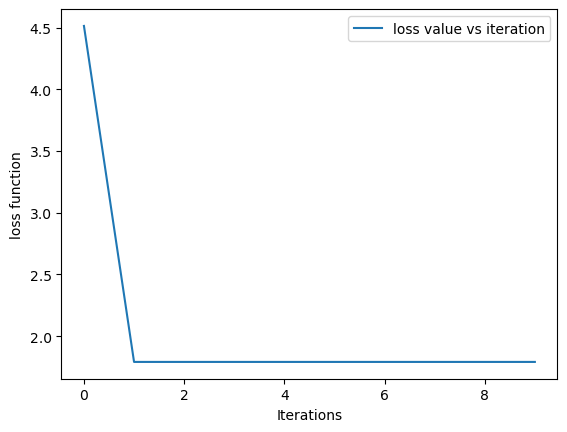

In [219]:
nn = NeuralNetwork(images,labels)
nn.loss=[]
iterations =[]

for i in range(10):
    print("befor feedforward",i)
    nn.feedforward()
    print("befor backprop",i)
    
    nn.backprop(l_rate=0.005)
    iterations.append(i)

print(nn.loss)
loss = np.array(nn.loss)

plt.plot(iterations, loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

In [217]:
# X_test هو مجموعة البيانات للاختبار، وY_test هي الفئات الصحيحة لتلك البيانات.
accuracy = nn.accuracy(images, labels)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 15.61%


befor feedforward 0
befor backprop 0
befor feedforward 1
befor backprop 1
befor feedforward 2
befor backprop 2
befor feedforward 3
befor backprop 3
befor feedforward 4
befor backprop 4
befor feedforward 5
befor backprop 5
befor feedforward 6
befor backprop 6
befor feedforward 7
befor backprop 7
befor feedforward 8
befor backprop 8
befor feedforward 9
befor backprop 9
[8.378990601171987, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483]


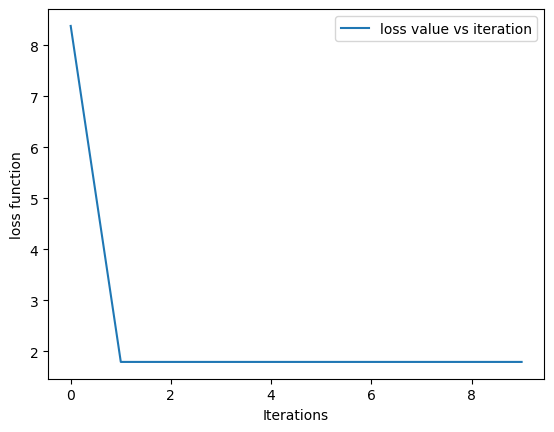

In [220]:
nn = NeuralNetwork(images,labels)
nn.loss=[]
iterations =[]

for i in range(10):
    print("befor feedforward",i)
    nn.feedforward()
    print("befor backprop",i)
    nn.backprop_rprop()
    iterations.append(i)

print(nn.loss)
loss = np.array(nn.loss)

plt.plot(iterations, nn.loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

In [211]:
# X_test هو مجموعة البيانات للاختبار، وY_test هي الفئات الصحيحة لتلك البيانات.
accuracy = nn.accuracy(images, labels)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 17.13%


befor feedforward 0
befor backprop 0
befor feedforward 1
befor backprop 1
befor feedforward 2
befor backprop 2
befor feedforward 3
befor backprop 3
befor feedforward 4
befor backprop 4
befor feedforward 5
befor backprop 5
befor feedforward 6
befor backprop 6
befor feedforward 7
befor backprop 7
befor feedforward 8
befor backprop 8
befor feedforward 9
befor backprop 9
[5.0344056851888315, 1.7917594692280483, 1.7917594692280483, 1.7917594692280483, 1.7940928750229523, 1.7940928750229523, 1.7940928750229523, 1.7940928750229523, 1.7964262808178566, 1.7940928750229523]


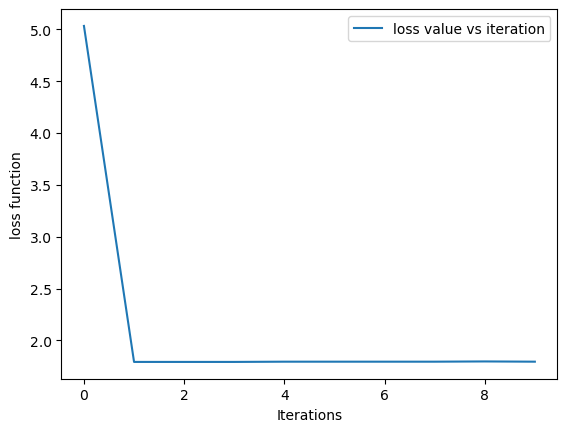

In [221]:
nn = NeuralNetwork(images,labels)
nn.loss=[]
iterations =[]

for i in range(10):
    print("befor feedforward",i)
    nn.feedforward()
    print("befor backprop",i)
    nn.train_bayesian(0.005)
    iterations.append(i)

print(nn.loss)
loss = np.array(nn.loss)

plt.plot(iterations, loss, label='loss value vs iteration')
plt.xlabel('Iterations')
plt.ylabel('loss function')
plt.legend()
plt.show()

In [213]:
# X_test هو مجموعة البيانات للاختبار، وY_test هي الفئات الصحيحة لتلك البيانات.
accuracy = nn.accuracy(images, labels)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 16.20%


In [344]:
from keras.backend import clear_session
clear_session()

In [345]:
model = Sequential()

model.add(Dense(1024,input_dim=images.shape[1] , activation='relu'))  
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(1024, activation='relu')) 
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))  
# model.add(Dense(32, activation='relu')) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu')) 
# model.add(Dense(128, activation='relu')) 

# model.add(Dense(16, activation='relu'))  
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.2))
model.add(Dense(len(label_to_number), activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              16778240  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 128)               3

In [271]:
history = model.fit(images, labels, epochs=10, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/10
55/55 [==============================] - 15s 255ms/step - loss: 1.8241 - accuracy: 0.2033 - val_loss: 1.7417 - val_accuracy: 0.2297
Epoch 2/10
55/55 [==============================] - 14s 250ms/step - loss: 1.6940 - accuracy: 0.2772 - val_loss: 1.6121 - val_accuracy: 0.3283
Epoch 3/10
55/55 [==============================] - 14s 249ms/step - loss: 1.6041 - accuracy: 0.3431 - val_loss: 1.5347 - val_accuracy: 0.4133
Epoch 4/10
55/55 [==============================] - 14s 255ms/step - loss: 1.5574 - accuracy: 0.3769 - val_loss: 1.5370 - val_accuracy: 0.4033
Epoch 5/10
55/55 [==============================] - 13s 242ms/step - loss: 1.5250 - accuracy: 0.4003 - val_loss: 1.4852 - val_accuracy: 0.4253
Epoch 6/10
55/55 [==============================] - 14s 252ms/step - loss: 1.4879 - accuracy: 0.4144 - val_loss: 1.4615 - val_accuracy: 0.4343
Epoch 7/10
55/55 [==============================] - 13s 237ms/step - loss: 1.4457 - accuracy: 0.4384 - val_loss: 1.4174 - val_accuracy: 0.4383

In [272]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 16ms/step - loss: 1.3756 - accuracy: 0.4607
Loss: 1.37562894821167, Accuracy: 0.4606666564941406


In [273]:
history = model.fit(images, labels, epochs=20, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/20
55/55 [==============================] - 14s 247ms/step - loss: 1.3732 - accuracy: 0.4676 - val_loss: 1.3806 - val_accuracy: 0.4447
Epoch 2/20
55/55 [==============================] - 13s 245ms/step - loss: 1.3543 - accuracy: 0.4723 - val_loss: 1.3423 - val_accuracy: 0.4710
Epoch 3/20
55/55 [==============================] - 14s 250ms/step - loss: 1.3378 - accuracy: 0.4789 - val_loss: 1.3564 - val_accuracy: 0.4637
Epoch 4/20
55/55 [==============================] - 13s 244ms/step - loss: 1.3307 - accuracy: 0.4805 - val_loss: 1.3686 - val_accuracy: 0.4613
Epoch 5/20
55/55 [==============================] - 14s 246ms/step - loss: 1.2992 - accuracy: 0.5004 - val_loss: 1.3418 - val_accuracy: 0.4730
Epoch 6/20
55/55 [==============================] - 13s 244ms/step - loss: 1.3050 - accuracy: 0.4959 - val_loss: 1.3564 - val_accuracy: 0.4587
Epoch 7/20
55/55 [==============================] - 13s 240ms/step - loss: 1.2761 - accuracy: 0.5105 - val_loss: 1.3474 - val_accuracy: 0.4747

In [274]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 1.3907 - accuracy: 0.4813
Loss: 1.3906580209732056, Accuracy: 0.48133334517478943


In [275]:
history = model.fit(images, labels, epochs=10, batch_size=128,validation_data=(images_test,labels_test))

Epoch 1/10
110/110 [==============================] - 22s 200ms/step - loss: 1.1553 - accuracy: 0.5494 - val_loss: 1.4646 - val_accuracy: 0.4570
Epoch 2/10
110/110 [==============================] - 21s 194ms/step - loss: 1.1435 - accuracy: 0.5607 - val_loss: 1.4182 - val_accuracy: 0.4550
Epoch 3/10
110/110 [==============================] - 21s 192ms/step - loss: 1.1087 - accuracy: 0.5753 - val_loss: 1.4860 - val_accuracy: 0.4700
Epoch 4/10
110/110 [==============================] - 21s 188ms/step - loss: 1.1051 - accuracy: 0.5779 - val_loss: 1.3850 - val_accuracy: 0.4737
Epoch 5/10
110/110 [==============================] - 22s 196ms/step - loss: 1.0690 - accuracy: 0.5928 - val_loss: 1.3746 - val_accuracy: 0.4800
Epoch 6/10
110/110 [==============================] - 22s 200ms/step - loss: 1.0456 - accuracy: 0.6006 - val_loss: 1.4366 - val_accuracy: 0.4870
Epoch 7/10
110/110 [==============================] - 23s 206ms/step - loss: 1.0343 - accuracy: 0.6074 - val_loss: 1.4472 - val_ac

In [277]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 1.4303 - accuracy: 0.4917
Loss: 1.4302805662155151, Accuracy: 0.49166667461395264


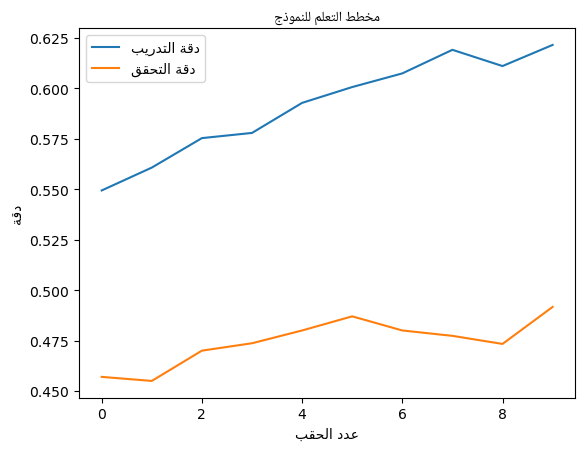

In [290]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [291]:
history = model.fit(images, labels, epochs=10, batch_size=64,validation_data=(images_test,labels_test))

Epoch 1/10
220/220 [==============================] - 43s 194ms/step - loss: 1.1011 - accuracy: 0.5745 - val_loss: 1.4253 - val_accuracy: 0.4653
Epoch 2/10
220/220 [==============================] - 42s 191ms/step - loss: 1.0793 - accuracy: 0.5879 - val_loss: 1.4370 - val_accuracy: 0.4597
Epoch 3/10
220/220 [==============================] - 43s 196ms/step - loss: 1.0524 - accuracy: 0.5989 - val_loss: 1.6362 - val_accuracy: 0.4383
Epoch 4/10
220/220 [==============================] - 37s 167ms/step - loss: 1.0402 - accuracy: 0.6005 - val_loss: 1.8403 - val_accuracy: 0.3570
Epoch 5/10
220/220 [==============================] - 37s 168ms/step - loss: 1.0627 - accuracy: 0.5918 - val_loss: 1.4550 - val_accuracy: 0.4623
Epoch 6/10
220/220 [==============================] - 37s 169ms/step - loss: 1.0126 - accuracy: 0.6084 - val_loss: 1.4850 - val_accuracy: 0.4723
Epoch 7/10
220/220 [==============================] - 35s 159ms/step - loss: 1.0051 - accuracy: 0.6158 - val_loss: 1.5216 - val_ac

In [292]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

25/94 [======>.......................] - ETA: 1s - loss: 2.0056 - accuracy: 0.3638

94/94 [==============================] - 3s 29ms/step - loss: 1.5537 - accuracy: 0.4583
Loss: 1.5537199974060059, Accuracy: 0.4583333432674408


In [293]:
history = model.fit(images, labels, epochs=10, batch_size=32,validation_data=(images_test,labels_test))

Epoch 1/10
439/439 [==============================] - 99s 226ms/step - loss: 1.1209 - accuracy: 0.5715 - val_loss: 1.4584 - val_accuracy: 0.4627
Epoch 2/10
439/439 [==============================] - 554s 1s/step - loss: 1.1035 - accuracy: 0.5775 - val_loss: 1.5486 - val_accuracy: 0.4287
Epoch 3/10
439/439 [==============================] - 100s 228ms/step - loss: 1.0701 - accuracy: 0.5844 - val_loss: 1.4768 - val_accuracy: 0.4807
Epoch 4/10
439/439 [==============================] - 99s 226ms/step - loss: 1.0411 - accuracy: 0.6019 - val_loss: 1.5310 - val_accuracy: 0.4540
Epoch 5/10
439/439 [==============================] - 98s 224ms/step - loss: 1.0468 - accuracy: 0.5989 - val_loss: 1.4332 - val_accuracy: 0.4767
Epoch 6/10
439/439 [==============================] - 954s 2s/step - loss: 1.0104 - accuracy: 0.6141 - val_loss: 1.5677 - val_accuracy: 0.4487
Epoch 7/10
439/439 [==============================] - 100s 227ms/step - loss: 1.0035 - accuracy: 0.6221 - val_loss: 1.4669 - val_accu

In [294]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

33/94 [=========>....................] - ETA: 1s - loss: 1.6577 - accuracy: 0.4697

94/94 [==============================] - 3s 32ms/step - loss: 1.4894 - accuracy: 0.4720
Loss: 1.489410638809204, Accuracy: 0.47200000286102295


In [295]:
history = model.fit(images, labels, epochs=10, batch_size=16,validation_data=(images_test,labels_test))

Epoch 1/10
878/878 [==============================] - 175s 199ms/step - loss: 1.1529 - accuracy: 0.5565 - val_loss: 1.3987 - val_accuracy: 0.4703
Epoch 2/10
878/878 [==============================] - 164s 187ms/step - loss: 1.1149 - accuracy: 0.5775 - val_loss: 1.4724 - val_accuracy: 0.4573
Epoch 3/10
878/878 [==============================] - 169s 192ms/step - loss: 1.1208 - accuracy: 0.5775 - val_loss: 1.4305 - val_accuracy: 0.4743
Epoch 4/10
878/878 [==============================] - 175s 199ms/step - loss: 1.0894 - accuracy: 0.5830 - val_loss: 1.4179 - val_accuracy: 0.4660
Epoch 5/10
878/878 [==============================] - 205s 233ms/step - loss: 1.0524 - accuracy: 0.6020 - val_loss: 1.5471 - val_accuracy: 0.4443
Epoch 6/10
878/878 [==============================] - 194s 221ms/step - loss: 1.0506 - accuracy: 0.5989 - val_loss: 1.4571 - val_accuracy: 0.4703
Epoch 7/10
878/878 [==============================] - 193s 220ms/step - loss: 1.0367 - accuracy: 0.6087 - val_loss: 1.5470 -

In [296]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 12ms/step - loss: 1.5302 - accuracy: 0.4707
Loss: 1.5301846265792847, Accuracy: 0.47066667675971985


In [297]:
history = model.fit(images, labels, epochs=20, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/20
55/55 [==============================] - 13s 227ms/step - loss: 0.7934 - accuracy: 0.7020 - val_loss: 1.5405 - val_accuracy: 0.4957
Epoch 2/20
55/55 [==============================] - 12s 218ms/step - loss: 0.7192 - accuracy: 0.7295 - val_loss: 1.6247 - val_accuracy: 0.5023
Epoch 3/20
55/55 [==============================] - 14s 260ms/step - loss: 0.6959 - accuracy: 0.7359 - val_loss: 1.6586 - val_accuracy: 0.4987
Epoch 4/20
55/55 [==============================] - 13s 229ms/step - loss: 0.6756 - accuracy: 0.7426 - val_loss: 1.7235 - val_accuracy: 0.4973
Epoch 5/20
55/55 [==============================] - 13s 228ms/step - loss: 0.6735 - accuracy: 0.7406 - val_loss: 1.7439 - val_accuracy: 0.4950
Epoch 6/20
55/55 [==============================] - 12s 220ms/step - loss: 0.6594 - accuracy: 0.7489 - val_loss: 1.7858 - val_accuracy: 0.4970
Epoch 7/20
55/55 [==============================] - 12s 224ms/step - loss: 0.6420 - accuracy: 0.7571 - val_loss: 1.8779 - val_accuracy: 0.4960

In [298]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 12ms/step - loss: 2.2566 - accuracy: 0.4807
Loss: 2.256647825241089, Accuracy: 0.4806666672229767


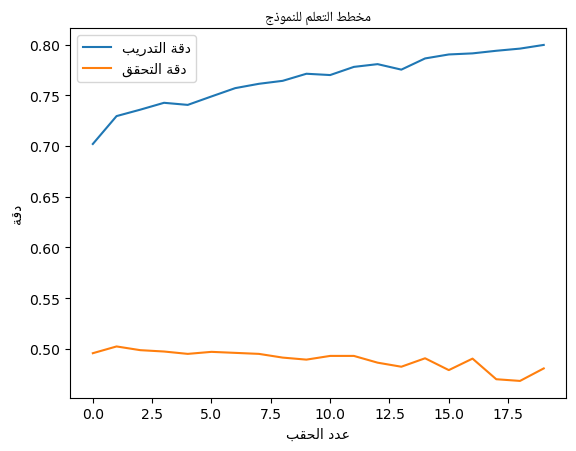

In [299]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [300]:
learning_rate = 0.0003  
beta_1 = 0.9           
beta_2 = 0.999        
epsilon = 1e-07        

adam = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)


In [301]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [302]:
history = model.fit(images, labels, epochs=10, batch_size=128,validation_data=(images_test,labels_test))

Epoch 1/10
110/110 [==============================] - 23s 187ms/step - loss: 0.5023 - accuracy: 0.8080 - val_loss: 2.4876 - val_accuracy: 0.4747
Epoch 2/10
110/110 [==============================] - 20s 185ms/step - loss: 0.4950 - accuracy: 0.8148 - val_loss: 2.4589 - val_accuracy: 0.4760
Epoch 3/10
110/110 [==============================] - 23s 207ms/step - loss: 0.4960 - accuracy: 0.8130 - val_loss: 2.4090 - val_accuracy: 0.4727
Epoch 4/10
110/110 [==============================] - 22s 203ms/step - loss: 0.4846 - accuracy: 0.8123 - val_loss: 2.4981 - val_accuracy: 0.4670
Epoch 5/10
110/110 [==============================] - 21s 193ms/step - loss: 0.4776 - accuracy: 0.8183 - val_loss: 2.5929 - val_accuracy: 0.4610
Epoch 6/10
110/110 [==============================] - 23s 207ms/step - loss: 0.4738 - accuracy: 0.8219 - val_loss: 2.6560 - val_accuracy: 0.4727
Epoch 7/10
110/110 [==============================] - 22s 197ms/step - loss: 0.4542 - accuracy: 0.8286 - val_loss: 2.6333 - val_ac

In [303]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 2.8870 - accuracy: 0.4673
Loss: 2.886967420578003, Accuracy: 0.4673333466053009


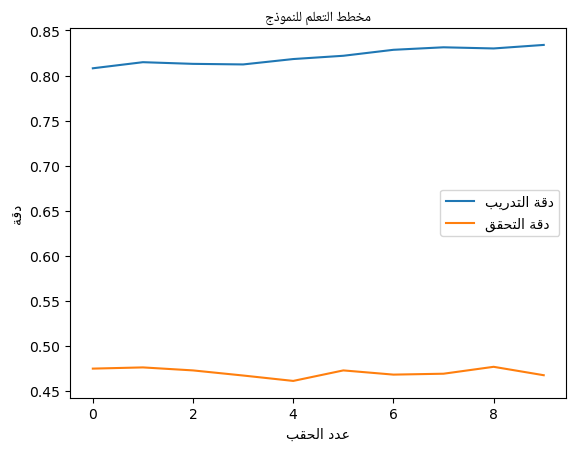

In [304]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [305]:
history = model.fit(images, labels, epochs=10, batch_size=64,validation_data=(images_test,labels_test))

Epoch 1/10
220/220 [==============================] - 42s 189ms/step - loss: 0.4980 - accuracy: 0.8137 - val_loss: 2.5335 - val_accuracy: 0.4703
Epoch 2/10
220/220 [==============================] - 40s 180ms/step - loss: 0.4653 - accuracy: 0.8236 - val_loss: 2.7137 - val_accuracy: 0.4680
Epoch 3/10
220/220 [==============================] - 37s 169ms/step - loss: 0.4653 - accuracy: 0.8252 - val_loss: 2.5472 - val_accuracy: 0.4693
Epoch 4/10
220/220 [==============================] - 38s 173ms/step - loss: 0.4412 - accuracy: 0.8359 - val_loss: 2.6954 - val_accuracy: 0.4713
Epoch 5/10
220/220 [==============================] - 38s 174ms/step - loss: 0.4316 - accuracy: 0.8358 - val_loss: 2.7426 - val_accuracy: 0.4550
Epoch 6/10
220/220 [==============================] - 35s 159ms/step - loss: 0.4296 - accuracy: 0.8386 - val_loss: 2.7854 - val_accuracy: 0.4617
Epoch 7/10
220/220 [==============================] - 36s 164ms/step - loss: 0.4236 - accuracy: 0.8415 - val_loss: 2.8915 - val_ac

In [306]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 2.9528 - accuracy: 0.4690
Loss: 2.952810287475586, Accuracy: 0.4690000116825104


جيب عمل كلير سيشن و رن للموديل قبل ان نقوم بعمل رن لباقي الكود من أجل أن لا يكون قد حفظ البيانات

In [316]:
learning_rate = 0.00003
beta_1 = 0.8           
beta_2 = 0.999        
epsilon = 1e-07        

adam = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

In [317]:
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(images, labels, epochs=10, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/10
55/55 [==============================] - 16s 254ms/step - loss: 1.7084 - accuracy: 0.2698 - val_loss: 1.6148 - val_accuracy: 0.3337
Epoch 2/10
55/55 [==============================] - 14s 252ms/step - loss: 1.6204 - accuracy: 0.3266 - val_loss: 1.5671 - val_accuracy: 0.3537
Epoch 3/10
55/55 [==============================] - 14s 248ms/step - loss: 1.5787 - accuracy: 0.3528 - val_loss: 1.5306 - val_accuracy: 0.3693
Epoch 4/10
55/55 [==============================] - 13s 241ms/step - loss: 1.5507 - accuracy: 0.3632 - val_loss: 1.5249 - val_accuracy: 0.3823
Epoch 5/10
55/55 [==============================] - 12s 213ms/step - loss: 1.5372 - accuracy: 0.3730 - val_loss: 1.5129 - val_accuracy: 0.3810
Epoch 6/10
55/55 [==============================] - 13s 237ms/step - loss: 1.5115 - accuracy: 0.3828 - val_loss: 1.4750 - val_accuracy: 0.3907
Epoch 7/10
55/55 [==============================] - 13s 228ms/step - loss: 1.4882 - accuracy: 0.3935 - val_loss: 1.4606 - val_accuracy: 0.4033

In [318]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 1.4331 - accuracy: 0.4193
Loss: 1.4331049919128418, Accuracy: 0.4193333387374878


In [319]:
history = model.fit(images, labels, epochs=10, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/10
55/55 [==============================] - 16s 267ms/step - loss: 1.4318 - accuracy: 0.4193 - val_loss: 1.4433 - val_accuracy: 0.4207
Epoch 2/10
55/55 [==============================] - 13s 243ms/step - loss: 1.4153 - accuracy: 0.4268 - val_loss: 1.4174 - val_accuracy: 0.4167
Epoch 3/10
55/55 [==============================] - 15s 265ms/step - loss: 1.3970 - accuracy: 0.4370 - val_loss: 1.3976 - val_accuracy: 0.4330
Epoch 4/10
55/55 [==============================] - 13s 238ms/step - loss: 1.3924 - accuracy: 0.4453 - val_loss: 1.4602 - val_accuracy: 0.4060
Epoch 5/10
55/55 [==============================] - 12s 221ms/step - loss: 1.3698 - accuracy: 0.4536 - val_loss: 1.4287 - val_accuracy: 0.4127
Epoch 6/10
55/55 [==============================] - 12s 223ms/step - loss: 1.3455 - accuracy: 0.4694 - val_loss: 1.3624 - val_accuracy: 0.4420
Epoch 7/10
55/55 [==============================] - 12s 216ms/step - loss: 1.3417 - accuracy: 0.4622 - val_loss: 1.3431 - val_accuracy: 0.4527

In [320]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 1.3539 - accuracy: 0.4433
Loss: 1.353949785232544, Accuracy: 0.44333332777023315


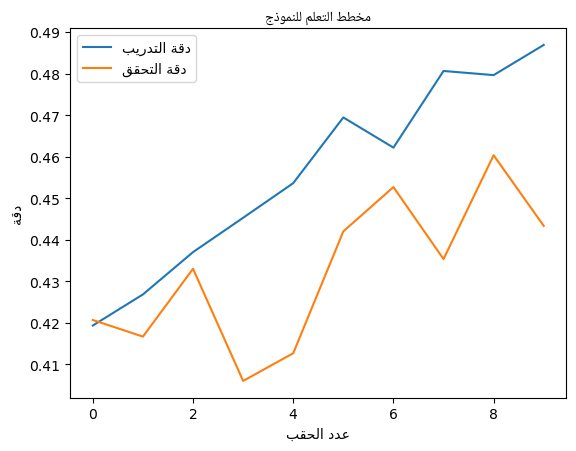

In [321]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [ ]:
history = model.fit(images, labels, epochs=100, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/100
220/220 [==============================] - 1s 3ms/step - loss: 0.1341 - accuracy: 0.9527
Epoch 2/100
220/220 [==============================] - 1s 3ms/step - loss: 0.1317 - accuracy: 0.9535
Epoch 3/100
220/220 [==============================] - 1s 3ms/step - loss: 0.1318 - accuracy: 0.9532
Epoch 4/100
220/220 [==============================] - 1s 4ms/step - loss: 0.1301 - accuracy: 0.9544
Epoch 5/100
220/220 [==============================] - 1s 4ms/step - loss: 0.1313 - accuracy: 0.9530
Epoch 6/100
220/220 [==============================] - 1s 3ms/step - loss: 0.1309 - accuracy: 0.9528
Epoch 7/100
220/220 [==============================] - 1s 4ms/step - loss: 0.1281 - accuracy: 0.9535
Epoch 8/100
220/220 [==============================] - 1s 4ms/step - loss: 0.1272 - accuracy: 0.9558
Epoch 9/100
220/220 [==============================] - 1s 3ms/step - loss: 0.1258 - accuracy: 0.9560
Epoch 10/100
220/220 [==============================] - 1s 4ms/step - loss: 0.1259 - accura

In [ ]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 0s 2ms/step - loss: 8.3067 - accuracy: 0.5190
Loss: 8.30672550201416, Accuracy: 0.5189999938011169


In [322]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(images, labels, epochs=10, batch_size=256,validation_data=(images_test,labels_test))

Epoch 1/10
55/55 [==============================] - 8s 124ms/step - loss: 1.3466 - accuracy: 0.4750 - val_loss: 1.3630 - val_accuracy: 0.4613
Epoch 2/10
55/55 [==============================] - 6s 113ms/step - loss: 1.2931 - accuracy: 0.4954 - val_loss: 1.4617 - val_accuracy: 0.4167
Epoch 3/10
55/55 [==============================] - 6s 117ms/step - loss: 1.2994 - accuracy: 0.4986 - val_loss: 1.3343 - val_accuracy: 0.4700
Epoch 4/10
55/55 [==============================] - 7s 121ms/step - loss: 1.2899 - accuracy: 0.5005 - val_loss: 1.3470 - val_accuracy: 0.4617
Epoch 5/10
55/55 [==============================] - 7s 130ms/step - loss: 1.2819 - accuracy: 0.5021 - val_loss: 1.3527 - val_accuracy: 0.4507
Epoch 6/10
55/55 [==============================] - 7s 128ms/step - loss: 1.2536 - accuracy: 0.5182 - val_loss: 1.3792 - val_accuracy: 0.4580
Epoch 7/10
55/55 [==============================] - 7s 132ms/step - loss: 1.2573 - accuracy: 0.5206 - val_loss: 1.3401 - val_accuracy: 0.4633
Epoch 

In [323]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 13ms/step - loss: 1.3986 - accuracy: 0.4497
Loss: 1.3985607624053955, Accuracy: 0.44966667890548706


In [324]:
history = model.fit(images, labels, epochs=10, batch_size=128,validation_data=(images_test,labels_test))

Epoch 1/10
110/110 [==============================] - 11s 100ms/step - loss: 1.2582 - accuracy: 0.5125 - val_loss: 1.2863 - val_accuracy: 0.4877
Epoch 2/10
110/110 [==============================] - 10s 93ms/step - loss: 1.2578 - accuracy: 0.5169 - val_loss: 1.4007 - val_accuracy: 0.4573
Epoch 3/10
110/110 [==============================] - 10s 90ms/step - loss: 1.2322 - accuracy: 0.5304 - val_loss: 1.3305 - val_accuracy: 0.4723
Epoch 4/10
110/110 [==============================] - 10s 93ms/step - loss: 1.2177 - accuracy: 0.5324 - val_loss: 1.3111 - val_accuracy: 0.4900
Epoch 5/10
110/110 [==============================] - 9s 84ms/step - loss: 1.1884 - accuracy: 0.5480 - val_loss: 1.3401 - val_accuracy: 0.4743
Epoch 6/10
110/110 [==============================] - 9s 84ms/step - loss: 1.1826 - accuracy: 0.5504 - val_loss: 1.3916 - val_accuracy: 0.4480
Epoch 7/10
110/110 [==============================] - 10s 88ms/step - loss: 1.1862 - accuracy: 0.5434 - val_loss: 1.5757 - val_accuracy: 

In [325]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 13ms/step - loss: 1.3032 - accuracy: 0.4920
Loss: 1.3031507730484009, Accuracy: 0.492000013589859


In [326]:
history = model.fit(images, labels, epochs=10, batch_size=64,validation_data=(images_test,labels_test))

Epoch 1/10
220/220 [==============================] - 17s 75ms/step - loss: 1.2085 - accuracy: 0.5401 - val_loss: 1.3298 - val_accuracy: 0.4760
Epoch 2/10
220/220 [==============================] - 16s 72ms/step - loss: 1.1900 - accuracy: 0.5411 - val_loss: 1.3579 - val_accuracy: 0.4777
Epoch 3/10
220/220 [==============================] - 15s 66ms/step - loss: 1.1737 - accuracy: 0.5527 - val_loss: 1.3279 - val_accuracy: 0.4800
Epoch 4/10
220/220 [==============================] - 13s 61ms/step - loss: 1.1473 - accuracy: 0.5638 - val_loss: 1.4606 - val_accuracy: 0.4533
Epoch 5/10
220/220 [==============================] - 13s 61ms/step - loss: 1.1392 - accuracy: 0.5693 - val_loss: 1.3293 - val_accuracy: 0.4777
Epoch 6/10
220/220 [==============================] - 13s 60ms/step - loss: 1.1071 - accuracy: 0.5791 - val_loss: 1.3065 - val_accuracy: 0.4967
Epoch 7/10
220/220 [==============================] - 13s 61ms/step - loss: 1.1094 - accuracy: 0.5786 - val_loss: 1.2856 - val_accuracy:

In [327]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 12ms/step - loss: 1.2916 - accuracy: 0.5033
Loss: 1.2916338443756104, Accuracy: 0.503333330154419


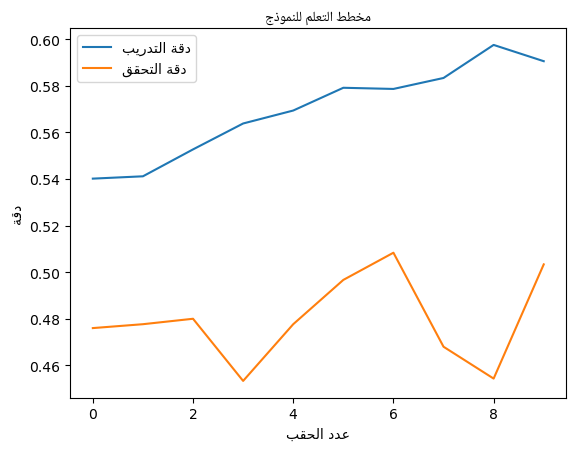

In [328]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [329]:
history = model.fit(images, labels, epochs=20, batch_size=64,validation_data=(images_test,labels_test))

Epoch 1/20
220/220 [==============================] - 14s 66ms/step - loss: 1.0432 - accuracy: 0.6032 - val_loss: 1.5303 - val_accuracy: 0.4067
Epoch 2/20
220/220 [==============================] - 14s 62ms/step - loss: 1.0257 - accuracy: 0.6113 - val_loss: 1.5239 - val_accuracy: 0.3947
Epoch 3/20
220/220 [==============================] - 13s 61ms/step - loss: 1.0257 - accuracy: 0.6154 - val_loss: 1.4263 - val_accuracy: 0.4433
Epoch 4/20
220/220 [==============================] - 13s 61ms/step - loss: 1.0135 - accuracy: 0.6194 - val_loss: 1.2906 - val_accuracy: 0.5023
Epoch 5/20
220/220 [==============================] - 14s 65ms/step - loss: 1.0131 - accuracy: 0.6164 - val_loss: 1.7225 - val_accuracy: 0.3980
Epoch 6/20
220/220 [==============================] - 14s 64ms/step - loss: 0.9835 - accuracy: 0.6305 - val_loss: 1.7545 - val_accuracy: 0.3857
Epoch 7/20
220/220 [==============================] - 14s 64ms/step - loss: 0.9761 - accuracy: 0.6385 - val_loss: 1.6729 - val_accuracy:

In [330]:
loss, accuracy = model.evaluate(images_test, labels_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

94/94 [==============================] - 1s 11ms/step - loss: 1.4882 - accuracy: 0.4947
Loss: 1.4882068634033203, Accuracy: 0.4946666657924652


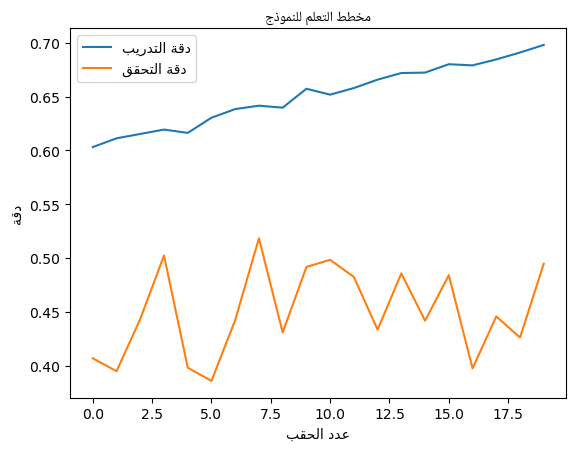

In [331]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [332]:
new_img = np.vstack((images, images_test))
new_leb = np.vstack((labels, labels_test))

In [333]:
new_img.shape

(17034, 16384)

In [334]:
new_leb.shape

(17034, 6)

In [335]:
X_train, X_test, y_train, y_test = train_test_split(new_img, new_leb, test_size=0.1)

In [336]:
X_test.shape

(1704, 16384)

In [337]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256,validation_data=(X_test,y_test))

Epoch 1/10
60/60 [==============================] - 9s 145ms/step - loss: 0.7727 - accuracy: 0.7271 - val_loss: 0.7137 - val_accuracy: 0.7477
Epoch 2/10
60/60 [==============================] - 7s 123ms/step - loss: 0.7292 - accuracy: 0.7420 - val_loss: 0.7187 - val_accuracy: 0.7424
Epoch 3/10
60/60 [==============================] - 7s 112ms/step - loss: 0.7259 - accuracy: 0.7399 - val_loss: 0.7286 - val_accuracy: 0.7418
Epoch 4/10
60/60 [==============================] - 7s 112ms/step - loss: 0.7094 - accuracy: 0.7464 - val_loss: 0.7393 - val_accuracy: 0.7430
Epoch 5/10
60/60 [==============================] - 7s 122ms/step - loss: 0.6984 - accuracy: 0.7489 - val_loss: 0.7156 - val_accuracy: 0.7471
Epoch 6/10
60/60 [==============================] - 7s 118ms/step - loss: 0.6817 - accuracy: 0.7560 - val_loss: 0.7034 - val_accuracy: 0.7453
Epoch 7/10
60/60 [==============================] - 7s 119ms/step - loss: 0.6888 - accuracy: 0.7528 - val_loss: 0.7255 - val_accuracy: 0.7459
Epoch 

In [338]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

54/54 [==============================] - 1s 13ms/step - loss: 0.7561 - accuracy: 0.7300
Loss: 0.756091833114624, Accuracy: 0.7300469279289246


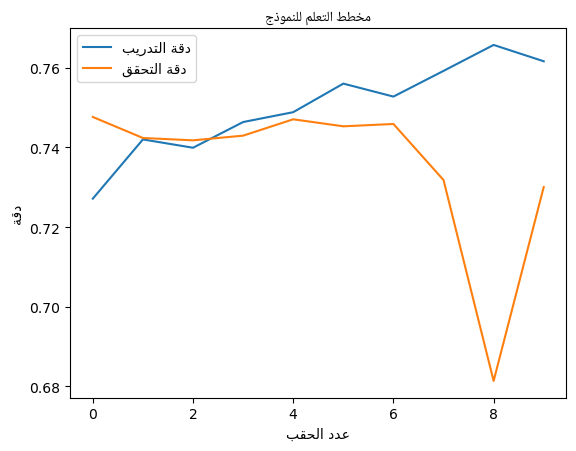

In [339]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [340]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256,validation_data=(X_test,y_test))

Epoch 1/10
60/60 [==============================] - 7s 119ms/step - loss: 0.6438 - accuracy: 0.7673 - val_loss: 0.7439 - val_accuracy: 0.7295
Epoch 2/10
60/60 [==============================] - 7s 113ms/step - loss: 0.6406 - accuracy: 0.7738 - val_loss: 0.7392 - val_accuracy: 0.7371
Epoch 3/10
60/60 [==============================] - 7s 124ms/step - loss: 0.6429 - accuracy: 0.7673 - val_loss: 0.7627 - val_accuracy: 0.7195
Epoch 4/10
60/60 [==============================] - 8s 128ms/step - loss: 0.6256 - accuracy: 0.7792 - val_loss: 0.7019 - val_accuracy: 0.7506
Epoch 5/10
60/60 [==============================] - 7s 115ms/step - loss: 0.6196 - accuracy: 0.7761 - val_loss: 0.7832 - val_accuracy: 0.7224
Epoch 6/10
60/60 [==============================] - 7s 113ms/step - loss: 0.6133 - accuracy: 0.7808 - val_loss: 0.9585 - val_accuracy: 0.6620
Epoch 7/10
60/60 [==============================] - 7s 120ms/step - loss: 0.6036 - accuracy: 0.7799 - val_loss: 0.7205 - val_accuracy: 0.7471
Epoch 

In [341]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

54/54 [==============================] - 1s 13ms/step - loss: 0.7612 - accuracy: 0.7295
Loss: 0.7611707448959351, Accuracy: 0.7294601202011108


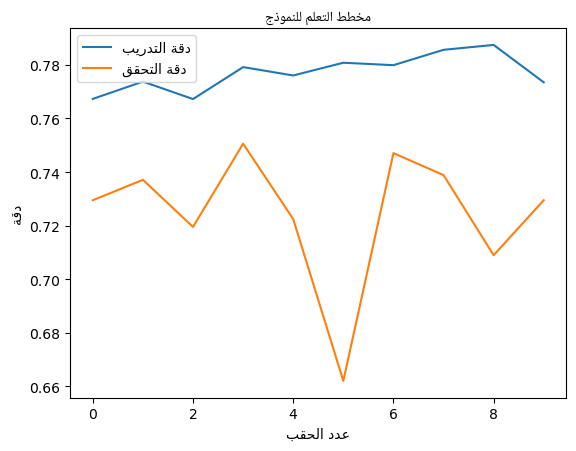

In [342]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [346]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [347]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256,validation_data=(X_test,y_test))

Epoch 1/10
60/60 [==============================] - 15s 221ms/step - loss: 1.8036 - accuracy: 0.2112 - val_loss: 1.7010 - val_accuracy: 0.2430
Epoch 2/10
60/60 [==============================] - 13s 214ms/step - loss: 1.6702 - accuracy: 0.2913 - val_loss: 1.6075 - val_accuracy: 0.3245
Epoch 3/10
60/60 [==============================] - 12s 208ms/step - loss: 1.6030 - accuracy: 0.3395 - val_loss: 1.5969 - val_accuracy: 0.3398
Epoch 4/10
60/60 [==============================] - 13s 210ms/step - loss: 1.5666 - accuracy: 0.3661 - val_loss: 1.5205 - val_accuracy: 0.3850
Epoch 5/10
60/60 [==============================] - 13s 213ms/step - loss: 1.5132 - accuracy: 0.3972 - val_loss: 1.5202 - val_accuracy: 0.3750
Epoch 6/10
60/60 [==============================] - 12s 208ms/step - loss: 1.4921 - accuracy: 0.4136 - val_loss: 1.4517 - val_accuracy: 0.4184
Epoch 7/10
60/60 [==============================] - 13s 209ms/step - loss: 1.4504 - accuracy: 0.4334 - val_loss: 1.4228 - val_accuracy: 0.4331

In [348]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

54/54 [==============================] - 1s 11ms/step - loss: 1.3999 - accuracy: 0.4607
Loss: 1.3999301195144653, Accuracy: 0.46068075299263


In [349]:
history = model.fit(X_train, y_train, epochs=20, batch_size=256,validation_data=(X_test,y_test))

Epoch 1/20
60/60 [==============================] - 15s 246ms/step - loss: 1.3420 - accuracy: 0.4778 - val_loss: 1.3562 - val_accuracy: 0.4736
Epoch 2/20
60/60 [==============================] - 15s 245ms/step - loss: 1.3181 - accuracy: 0.4906 - val_loss: 1.3334 - val_accuracy: 0.4830
Epoch 3/20
60/60 [==============================] - 14s 225ms/step - loss: 1.2879 - accuracy: 0.5073 - val_loss: 1.3547 - val_accuracy: 0.4795
Epoch 4/20
60/60 [==============================] - 13s 223ms/step - loss: 1.2887 - accuracy: 0.5038 - val_loss: 1.3316 - val_accuracy: 0.4847
Epoch 5/20
60/60 [==============================] - 13s 224ms/step - loss: 1.2624 - accuracy: 0.5185 - val_loss: 1.3530 - val_accuracy: 0.4748
Epoch 6/20
60/60 [==============================] - 13s 217ms/step - loss: 1.2475 - accuracy: 0.5220 - val_loss: 1.4489 - val_accuracy: 0.4296
Epoch 7/20
60/60 [==============================] - 13s 217ms/step - loss: 1.2450 - accuracy: 0.5245 - val_loss: 1.3858 - val_accuracy: 0.4671

In [350]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

54/54 [==============================] - 1s 12ms/step - loss: 1.4387 - accuracy: 0.4924
Loss: 1.438683271408081, Accuracy: 0.4923709034919739


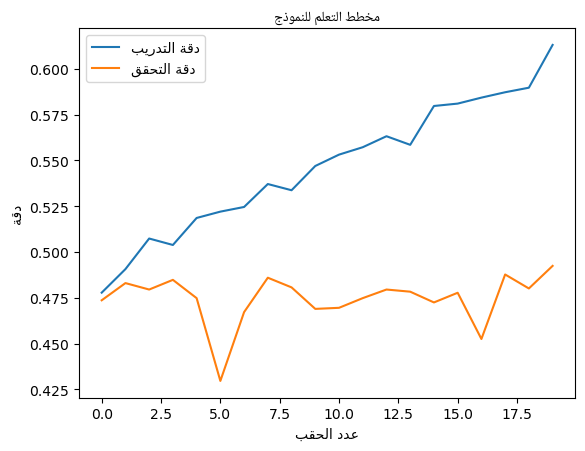

In [351]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()

In [352]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64,validation_data=(X_test,y_test))

Epoch 1/20
240/240 [==============================] - 40s 167ms/step - loss: 1.2488 - accuracy: 0.5197 - val_loss: 1.5545 - val_accuracy: 0.4425
Epoch 2/20
240/240 [==============================] - 39s 164ms/step - loss: 1.2095 - accuracy: 0.5321 - val_loss: 1.5171 - val_accuracy: 0.4155
Epoch 3/20
240/240 [==============================] - 40s 167ms/step - loss: 1.1675 - accuracy: 0.5521 - val_loss: 1.4918 - val_accuracy: 0.4507
Epoch 4/20
240/240 [==============================] - 40s 165ms/step - loss: 1.1497 - accuracy: 0.5575 - val_loss: 1.4155 - val_accuracy: 0.4660
Epoch 5/20
240/240 [==============================] - 40s 165ms/step - loss: 1.1442 - accuracy: 0.5581 - val_loss: 1.4048 - val_accuracy: 0.4501
Epoch 6/20
240/240 [==============================] - 40s 168ms/step - loss: 1.1243 - accuracy: 0.5693 - val_loss: 1.4052 - val_accuracy: 0.4906
Epoch 7/20
240/240 [==============================] - 41s 170ms/step - loss: 1.1068 - accuracy: 0.5734 - val_loss: 1.4478 - val_ac

In [353]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

54/54 [==============================] - 1s 12ms/step - loss: 1.5443 - accuracy: 0.4724
Loss: 1.5442718267440796, Accuracy: 0.47241783142089844


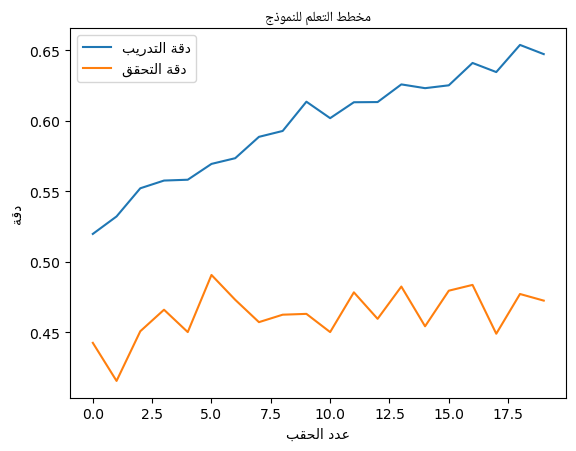

In [354]:
plt.figure()
plt.plot(history.history['accuracy'], label=get_display(arabic_reshaper.reshape('دقة التدريب')))
plt.plot(history.history['val_accuracy'], label=get_display(arabic_reshaper.reshape('دقة التحقق')))
plt.title(get_display(arabic_reshaper.reshape('مخطط التعلم للنموذج')), fontproperties=arabic_font)
plt.ylabel(get_display(arabic_reshaper.reshape('دقة')) )
plt.xlabel(get_display(arabic_reshaper.reshape('عدد الحقب')) )
plt.legend()
plt.show()